In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys, os
import numpy as np
import cv2
sys.path.append('../external/cocoapi/PythonAPI/')
from pycocotools.coco import COCO
sys.path.append('../external/maskrcnn-benchmark/demo')
sys.path.append('../external/maskrcnn-benchmark')
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

### Overview of this code
1. Iterate through all the images
    - For each image, run the facebook net once
    - Then adjust it with user input until it is decent
    - Save data periodically

In [7]:
# Same random seed
np.random.seed(0)

In [8]:
# Image dirs
dataDir = '../../data/input/coco'
print(os.listdir(dataDir))
dataType = 'val2017'
annDir = '{}/annotations'.format(dataDir)
annZipFile = '{}/annotations_train{}.zip'.format(dataDir, dataType)
annFile = '{}/instances_{}.json'.format(annDir, dataType)
annURL = 'http://images.cocodataset.org/annotations/annotations_train{}.zip'.format(dataType)
imgDir = '{}/images/{}'.format(dataDir, dataType)
print (annDir)
print (annFile)
print (annZipFile)
print (annURL)
print (imgDir)

# Mask RCNN dirs
configDir = '../external/maskrcnn-benchmark/configs/'
print (configDir)

['images', 'annotations']
../../data/input/coco/annotations
../../data/input/coco/annotations/instances_val2017.json
../../data/input/coco/annotations_trainval2017.zip
http://images.cocodataset.org/annotations/annotations_trainval2017.zip
../../data/input/coco/images/val2017
../external/maskrcnn-benchmark/configs/


In [9]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


In [44]:
# get all images containing given categories, select one at random
imgIds = coco.getImgIds();
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
img = coco.loadImgs(347544)[0]
# id = 347544

In [11]:
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

{'license': 1, 'file_name': '000000347544.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000347544.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-16 18:05:35', 'flickr_url': 'http://farm1.staticflickr.com/29/50050818_1d113a22bc_z.jpg', 'id': 347544}


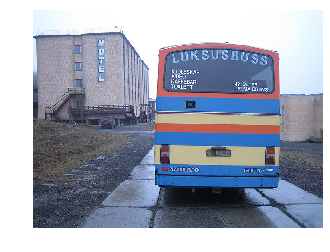

In [48]:
I = cv2.imread(os.path.join(imgDir, img['file_name']))
plt.axis('off')
imshow(I)
print(img)

[{'segmentation': [[474.61, 401.26, 442.25, 403.42, 379.69, 404.49, 320.36, 396.94, 271.82, 391.55, 254.56, 382.92, 244.85, 320.36, 259.96, 170.43, 270.74, 104.63, 280.45, 79.82, 293.39, 70.11, 357.03, 71.19, 421.75, 75.51, 491.87, 90.61, 541.48, 86.29, 557.66, 236.22, 547.96, 293.39, 542.56, 348.4, 545.8, 377.53, 546.88, 398.02, 523.15, 403.42, 491.87, 402.34, 467.06, 404.49]], 'area': 93964.45145000001, 'iscrowd': 0, 'image_id': 347544, 'bbox': [244.85, 70.11, 312.81, 334.38], 'category_id': 6, 'id': 164456}, {'segmentation': [[149.14, 252.28, 152.24, 233.55, 178.67, 232.93, 182.76, 244.22, 183.26, 255.39, 180.28, 258.12, 178.55, 255.76, 177.8, 254.02, 176.44, 254.39, 176.19, 260.6, 173.09, 261.22, 169.61, 258.98, 159.69, 257.5, 159.19, 256.75, 156.59, 257.12, 154.6, 261.09, 150.51, 259.98]], 'area': 797.0606999999999, 'iscrowd': 0, 'image_id': 347544, 'bbox': [149.14, 232.93, 34.12, 28.29], 'category_id': 8, 'id': 1369229}]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 .

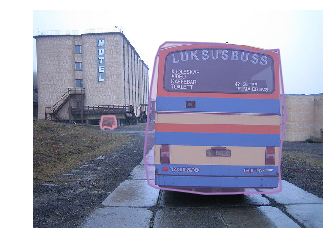

In [56]:
# load and display instance annotations
imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'])
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
print(anns)
print(coco.annToMask(anns[0]))

In [14]:
config_file = os.path.join(configDir, "caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml")
# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

In [19]:
coco_demo = COCODemo(
    cfg,
#     min_image_size=800,
    confidence_threshold=0.7,
)

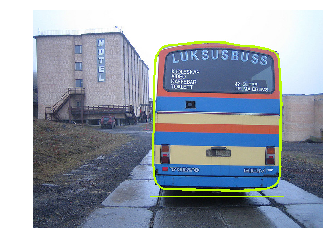

In [57]:
predictions = coco_demo.run_on_opencv_image(I)
imshow(predictions)

In [63]:
predictions = coco_demo.compute_prediction(I)
masks = predictions.get_field("mask").numpy()
print(masks.shape)

(2, 1, 480, 640)


(480, 640)


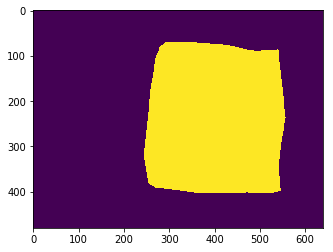

In [68]:
bus_annotation = get_largest_annotation(img['id'])
bus_mask = coco.annToMask(bus_annotation)
plt.imshow(bus_mask)
print(bus_mask.shape)

In [72]:
for mask in masks:
    iou = float((mask&bus_mask).sum())/((mask|bus_mask).sum())
    print(iou)

0.9237969746481842
0.0


In [73]:
def iou(mask1, mask2):
    return float((mask1&mask2).sum())/((mask1|mask2).sum())

def get_largest_annotation(img_id):
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)
    areas = [x['area'] for x in anns]
    idx_max = np.argmax(areas)
    return anns[idx_max]

def get_predicted_mask(I, actual_mask):
    predictions = coco_demo.compute_prediction(I)
    predicted_masks = predictions.get_field("mask").numpy()
    ious = [iou(predicted_mask, actual_mask) for predicted_mask in predicted_masks]
    idx_max = np.argmax(ious)
    return predicted_masks[idx_max]

0.9237969746481842


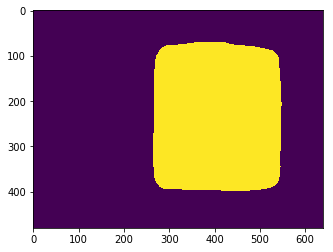

In [85]:
largest_annotation = get_largest_annotation(img['id'])
largest_mask = coco.annToMask(largest_annotation)
predicted_mask = get_predicted_mask(I, largest_mask).squeeze()
plt.imshow(predicted_mask)
print(iou(predicted_mask, largest_mask))
#hm

In [ ]:
# How should I update the mask to make it 'better'